## Data Wrangling and Feature Creation

# 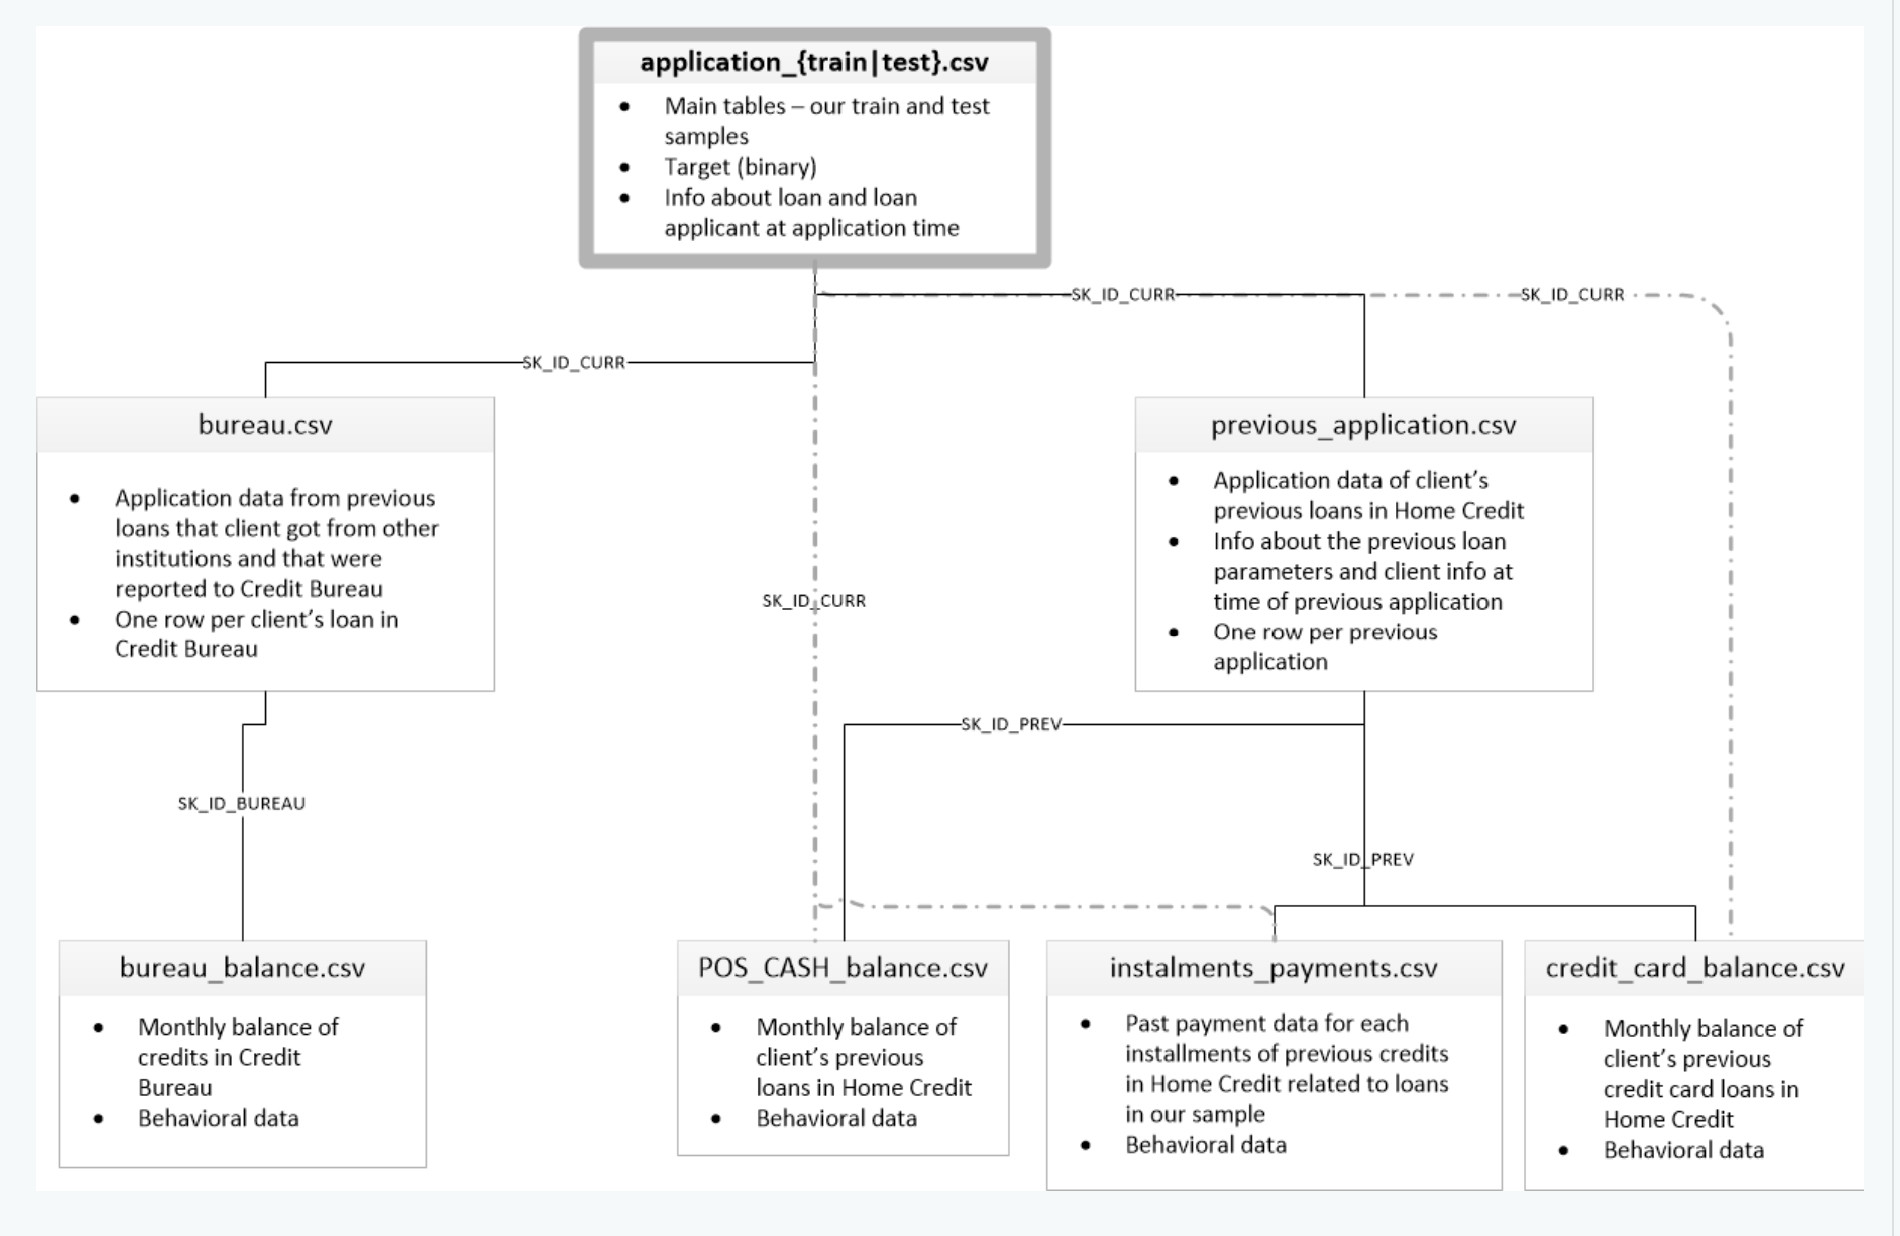

## Loading  Required Libraries

In [1]:
import time
import pandas as pd
import os
import numpy as np
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

### Defining functions to create new features and merge them with parent tables and repeating the process to 
### ultimately create a single data source (with relevant features) from the 7 different data sources  

In [2]:
#function to calculate count of classes of relevant variables for each loan applicant 
#(e.g. count the # of approved previous loans, # of cancelled previous loans etc. from the variable NAME_CONTRACT_STATUS)
#and then adding these new columns to the primary table

def mergetable(colname, pref, mtable):
    
    dftemp = pd.get_dummies(mtable, columns = [colname], prefix = pref)
    
    collist = list(dftemp.columns[dftemp.columns.str.startswith(pref)])
    
    collist.append('SK_ID_CURR')
    
    dftemp = dftemp.groupby('SK_ID_CURR', as_index = False).sum()[collist]
    
    df = pd.merge(mtable,dftemp,on = 'SK_ID_CURR', how = 'inner')
    
    return df

In [3]:
# function to merge tables
def callmerge(coldict, mtable):
    
    for i,(pref,colname) in enumerate(coldict.items()):
        
        mtable = mergetable(colname, pref, mtable)

        print("The Tables from iteration # {} are now merged\n" . format(i+1))

        if i == len(coldict) - 1:
            print("All tables are now merged")
            
    return mtable

In [4]:
start_time = time.time()

In [5]:
os.chdir('C:/Users/barun/Desktop/SB/Home-Credit-Project/')

In [6]:
print(os.getcwd())

C:\Users\barun\Desktop\SB\Home-Credit-Project


In [7]:
os.listdir()

['Data Story',
 'Data Wrangling Code',
 'dfeature.csv',
 'dfinal_updated_1.csv',
 'final presentation',
 'home_credit_datasets',
 'Inferential Statistics',
 'ML code',
 'technical process docs']

## Loading all the different 7 data sources in respective data frames

In [8]:
df_train = pd.read_csv("./home_credit_datasets/application_train.csv")
df0 = df_train.copy()

In [9]:
previous_app = pd.read_csv('./home_credit_datasets/previous_application.csv')
df2 = previous_app.copy()

In [10]:
bureau = pd.read_csv('./home_credit_datasets/bureau.csv')
df1 = bureau.copy()

bureau_bal = pd.read_csv('./home_credit_datasets/bureau_balance.csv')
df11 = bureau_bal.copy()

pos = pd.read_csv('./home_credit_datasets/POS_CASH_balance.csv')
df21 = pos.copy()

installments = pd.read_csv('./home_credit_datasets/installments_payments.csv')
df22 = installments.copy()

credit = pd.read_csv('./home_credit_datasets/credit_card_balance.csv')
df23 = credit.copy()

In [11]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [12]:
df0.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [13]:
df1.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [14]:
df11.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [15]:
df2.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.182832,0.867336,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
df21.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [17]:
df22.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


In [18]:
df23.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,1800.0,1800.0,0.000,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,2250.0,2250.0,60175.080,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,2250.0,2250.0,26926.425,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,11925.0,11925.0,224949.285,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,27000.0,27000.0,443044.395,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


In [19]:
df2['WEEKDAY_APPR_PROCESS_START'].value_counts()

TUESDAY      255118
WEDNESDAY    255010
MONDAY       253557
FRIDAY       252048
THURSDAY     249099
SATURDAY     240631
SUNDAY       164751
Name: WEEKDAY_APPR_PROCESS_START, dtype: int64

##  Converting weekday aplication Process start date as a numeric field

In [20]:
df2['WEEKDAY_APPR_PROCESS_START'] = df2['WEEKDAY_APPR_PROCESS_START'].map({'SUNDAY':0,'MONDAY': 1, 'TUESDAY':2, 'WEDNESDAY':3,'THURSDAY':4,
                                      'FRIDAY': 5, 'SATURDAY' : 6})

In [21]:
df2['WEEKDAY_APPR_PROCESS_START'].head(10)

0    6
1    4
2    2
3    1
4    4
5    6
6    2
7    1
8    1
9    6
Name: WEEKDAY_APPR_PROCESS_START, dtype: int64

## Feature Engineering on previous application data set to get the counts of different categories

In [22]:
df2['NAME_CONTRACT_STATUS'].value_counts()

Approved        1036781
Canceled         316319
Refused          290678
Unused offer      26436
Name: NAME_CONTRACT_STATUS, dtype: int64

In [23]:
df2['NAME_CONTRACT_TYPE'].value_counts()

Cash loans         747553
Consumer loans     729151
Revolving loans    193164
XNA                   346
Name: NAME_CONTRACT_TYPE, dtype: int64

In [24]:
df2['NAME_CASH_LOAN_PURPOSE'].value_counts()

XAP                                 922661
XNA                                 677918
Repairs                              23765
Other                                15608
Urgent needs                          8412
Buying a used car                     2888
Building a house or an annex          2693
Everyday expenses                     2416
Medicine                              2174
Payments on other loans               1931
Education                             1573
Journey                               1239
Purchase of electronic equipment      1061
Buying a new car                      1012
Wedding / gift / holiday               962
Buying a home                          865
Car repairs                            797
Furniture                              749
Buying a holiday home / land           533
Business development                   426
Gasification / water supply            300
Buying a garage                        136
Hobby                                   55
Money for a

In [25]:
df2['NAME_GOODS_CATEGORY'].value_counts()

XNA                         950809
Mobile                      224708
Consumer Electronics        121576
Computers                   105769
Audio/Video                  99441
Furniture                    53656
Photo / Cinema Equipment     25021
Construction Materials       24995
Clothing and Accessories     23554
Auto Accessories              7381
Jewelry                       6290
Homewares                     5023
Medical Supplies              3843
Vehicles                      3370
Sport and Leisure             2981
Gardening                     2668
Other                         2554
Office Appliances             2333
Tourism                       1659
Medicine                      1550
Direct Sales                   446
Fitness                        209
Additional Service             128
Education                      107
Weapon                          77
Insurance                       64
Animals                          1
House Construction               1
Name: NAME_GOODS_CAT

In [26]:
df2['NAME_CLIENT_TYPE'].value_counts()

Repeater     1231261
New           301363
Refreshed     135649
XNA             1941
Name: NAME_CLIENT_TYPE, dtype: int64

In [27]:
df2['CHANNEL_TYPE'].value_counts()

Credit and cash offices       719968
Country-wide                  494690
Stone                         212083
Regional / Local              108528
Contact center                 71297
AP+ (Cash loan)                57046
Channel of corporate sales      6150
Car dealer                       452
Name: CHANNEL_TYPE, dtype: int64

In [28]:
df2['NAME_TYPE_SUITE'].value_counts()

Unaccompanied      508970
Family             213263
Spouse, partner     67069
Children            31566
Other_B             17624
Other_A              9077
Group of people      2240
Name: NAME_TYPE_SUITE, dtype: int64

In [29]:
df2['NAME_PORTFOLIO'].value_counts()

POS      691011
Cash     461563
XNA      372230
Cards    144985
Cars        425
Name: NAME_PORTFOLIO, dtype: int64

In [30]:
df2['NAME_PRODUCT_TYPE'].value_counts()

XNA        1063666
x-sell      456287
walk-in     150261
Name: NAME_PRODUCT_TYPE, dtype: int64

In [31]:
df2['NAME_SELLER_INDUSTRY'].value_counts()

XNA                     855720
Consumer electronics    398265
Connectivity            276029
Furniture                57849
Construction             29781
Clothing                 23949
Industry                 19194
Auto technology           4990
Jewelry                   2709
MLM partners              1215
Tourism                    513
Name: NAME_SELLER_INDUSTRY, dtype: int64

### Defining the prefix of columns for which we intend to get the count of their classes/categories

In [32]:
coldict = {'PREV_NCS_COUNT' : 'NAME_CONTRACT_STATUS',
           'PREV_NCLT_COUNT' : 'NAME_CLIENT_TYPE',
           'PREV_NCT_COUNT' : 'NAME_CONTRACT_TYPE',
           'PREV_NCLP_COUNT' : 'NAME_CASH_LOAN_PURPOSE',
           'PREV_NTS_COUNT' : 'NAME_TYPE_SUITE',
           'PREV_NGC_COUNT' : 'NAME_GOODS_CATEGORY',
           'PREV_NPF_COUNT' : 'NAME_PORTFOLIO',
           'PREV_CT_COUNT' :  'CHANNEL_TYPE',
           'PREV_NPT_COUNT' : 'NAME_PRODUCT_TYPE',
           'PREV_NSI_COUNT' : 'NAME_SELLER_INDUSTRY'}

In [33]:
df2.shape

(1670214, 37)

### Calling the callmerge function to merge the new features created from previous_application data set and to merge it with the previos_application data set

In [34]:
df2 = callmerge(coldict,df2)

The Tables from iteration # 1 are now merged

The Tables from iteration # 2 are now merged

The Tables from iteration # 3 are now merged

The Tables from iteration # 4 are now merged

The Tables from iteration # 5 are now merged

The Tables from iteration # 6 are now merged

The Tables from iteration # 7 are now merged

The Tables from iteration # 8 are now merged

The Tables from iteration # 9 are now merged

The Tables from iteration # 10 are now merged

All tables are now merged


In [35]:
df2.shape

(1670214, 136)

In [36]:
df2.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL,PREV_NCS_COUNT_Approved,PREV_NCS_COUNT_Canceled,PREV_NCS_COUNT_Refused,PREV_NCS_COUNT_Unused offer,PREV_NCLT_COUNT_New,PREV_NCLT_COUNT_Refreshed,PREV_NCLT_COUNT_Repeater,PREV_NCLT_COUNT_XNA,PREV_NCT_COUNT_Cash loans,PREV_NCT_COUNT_Consumer loans,PREV_NCT_COUNT_Revolving loans,PREV_NCT_COUNT_XNA,PREV_NCLP_COUNT_Building a house or an annex,PREV_NCLP_COUNT_Business development,PREV_NCLP_COUNT_Buying a garage,PREV_NCLP_COUNT_Buying a holiday home / land,PREV_NCLP_COUNT_Buying a home,PREV_NCLP_COUNT_Buying a new car,PREV_NCLP_COUNT_Buying a used car,PREV_NCLP_COUNT_Car repairs,PREV_NCLP_COUNT_Education,PREV_NCLP_COUNT_Everyday expenses,PREV_NCLP_COUNT_Furniture,PREV_NCLP_COUNT_Gasification / water supply,PREV_NCLP_COUNT_Hobby,PREV_NCLP_COUNT_Journey,PREV_NCLP_COUNT_Medicine,PREV_NCLP_COUNT_Money for a third person,PREV_NCLP_COUNT_Other,PREV_NCLP_COUNT_Payments on other loans,PREV_NCLP_COUNT_Purchase of electronic equipment,PREV_NCLP_COUNT_Refusal to name the goal,PREV_NCLP_COUNT_Repairs,PREV_NCLP_COUNT_Urgent needs,PREV_NCLP_COUNT_Wedding / gift / holiday,PREV_NCLP_COUNT_XAP,PREV_NCLP_COUNT_XNA,PREV_NTS_COUNT_Children,PREV_NTS_COUNT_Family,PREV_NTS_COUNT_Group of people,PREV_NTS_COUNT_Other_A,PREV_NTS_COUNT_Other_B,"PREV_NTS_COUNT_Spouse, partner",PREV_NTS_COUNT_Unaccompanied,PREV_NGC_COUNT_Additional Service,PREV_NGC_COUNT_Animals,PREV_NGC_COUNT_Audio/Video,PREV_NGC_COUNT_Auto Accessories,PREV_NGC_COUNT_Clothing and Accessories,PREV_NGC_COUNT_Computers,PREV_NGC_COUNT_Construction Materials,PREV_NGC_COUNT_Consumer Electronics,PREV_NGC_COUNT_Direct Sales,PREV_NGC_COUNT_Education,PREV_NGC_COUNT_Fitness,PREV_NGC_COUNT_Furniture,PREV_NGC_COUNT_Gardening,PREV_NGC_COUNT_Homewares,PREV_NGC_COUNT_House Construction,PREV_NGC_COUNT_Insurance,PREV_NGC_COUNT_Jewelry,PREV_NGC_COUNT_Medical Supplies,PREV_NGC_COUNT_Medicine,PREV_NGC_COUNT_Mobile,PREV_NGC_COUNT_Office Appliances,PREV_NGC_COUNT_Other,PREV_NGC_COUNT_Photo / Cinema Equipment,PREV_NGC_COUNT_Sport and Leisure,PREV_NGC_COUNT_Tourism,PREV_NGC_COUNT_Vehicles,PREV_NGC_COUNT_Weapon,PREV_NGC_COUNT_XNA,PREV_NPF_COUNT_Cards,PREV_NPF_COUNT_Cars,PREV_NPF_COUNT_Cash,PREV_NPF_COUNT_POS,PREV_NPF_COUNT_XNA,PREV_CT_COUNT_AP+ (Cash loan),PREV_CT_COUNT_Car dealer,PREV_CT_COUNT_Channel of corporate sales,PREV_CT_COUNT_Contact center,PREV_CT_COUNT_Country-wide,PREV_CT_COUNT_Credit and cash offices,PREV_CT_COUNT_Regional / Local,PREV_CT_COUNT_Stone,PREV_NPT_COUNT_XNA,PREV_NPT_COUNT_walk-in,PREV_NPT_COUNT_x-sell,PREV_NSI_COUNT_Auto technology,PREV_NSI_COUNT_Clothing,PREV_NSI_COUNT_Connectivity,PREV_NSI_COUNT_Construction,PREV_NSI_COUNT_Consumer electronics,PREV_NSI_COUNT_Furniture,PREV_NSI_COUNT_Industry,PREV_NSI_COUNT_Jewelry,PREV_NSI_COUNT_MLM partners,PREV_NSI_COUNT_Tourism,PREV_NSI_COUNT_XNA
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,6,15,Y,1,0.000000,0.182832,0.867336,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0,2,0,1,0,1.0,0.0,2.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [37]:
# adding the number of previous loans taken by a current applicant as a feature
dftmp = df2.groupby('SK_ID_CURR', as_index = False).count()[['SK_ID_CURR','SK_ID_PREV']]
dftmp = dftmp.rename(columns = {'SK_ID_PREV' : 'PREV_LOAN_COUNT'})
dfplc = pd.merge(df2, dftmp, on = 'SK_ID_CURR', how = 'inner')

In [38]:
dfplc.shape

(1670214, 137)

In [39]:
dfplc.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL,PREV_NCS_COUNT_Approved,PREV_NCS_COUNT_Canceled,PREV_NCS_COUNT_Refused,PREV_NCS_COUNT_Unused offer,PREV_NCLT_COUNT_New,PREV_NCLT_COUNT_Refreshed,PREV_NCLT_COUNT_Repeater,PREV_NCLT_COUNT_XNA,PREV_NCT_COUNT_Cash loans,PREV_NCT_COUNT_Consumer loans,PREV_NCT_COUNT_Revolving loans,PREV_NCT_COUNT_XNA,PREV_NCLP_COUNT_Building a house or an annex,PREV_NCLP_COUNT_Business development,PREV_NCLP_COUNT_Buying a garage,PREV_NCLP_COUNT_Buying a holiday home / land,PREV_NCLP_COUNT_Buying a home,PREV_NCLP_COUNT_Buying a new car,PREV_NCLP_COUNT_Buying a used car,PREV_NCLP_COUNT_Car repairs,PREV_NCLP_COUNT_Education,PREV_NCLP_COUNT_Everyday expenses,PREV_NCLP_COUNT_Furniture,PREV_NCLP_COUNT_Gasification / water supply,PREV_NCLP_COUNT_Hobby,PREV_NCLP_COUNT_Journey,PREV_NCLP_COUNT_Medicine,PREV_NCLP_COUNT_Money for a third person,PREV_NCLP_COUNT_Other,PREV_NCLP_COUNT_Payments on other loans,PREV_NCLP_COUNT_Purchase of electronic equipment,PREV_NCLP_COUNT_Refusal to name the goal,PREV_NCLP_COUNT_Repairs,PREV_NCLP_COUNT_Urgent needs,PREV_NCLP_COUNT_Wedding / gift / holiday,PREV_NCLP_COUNT_XAP,PREV_NCLP_COUNT_XNA,PREV_NTS_COUNT_Children,PREV_NTS_COUNT_Family,PREV_NTS_COUNT_Group of people,PREV_NTS_COUNT_Other_A,PREV_NTS_COUNT_Other_B,"PREV_NTS_COUNT_Spouse, partner",PREV_NTS_COUNT_Unaccompanied,PREV_NGC_COUNT_Additional Service,PREV_NGC_COUNT_Animals,PREV_NGC_COUNT_Audio/Video,PREV_NGC_COUNT_Auto Accessories,PREV_NGC_COUNT_Clothing and Accessories,PREV_NGC_COUNT_Computers,PREV_NGC_COUNT_Construction Materials,PREV_NGC_COUNT_Consumer Electronics,PREV_NGC_COUNT_Direct Sales,PREV_NGC_COUNT_Education,PREV_NGC_COUNT_Fitness,PREV_NGC_COUNT_Furniture,PREV_NGC_COUNT_Gardening,PREV_NGC_COUNT_Homewares,PREV_NGC_COUNT_House Construction,PREV_NGC_COUNT_Insurance,PREV_NGC_COUNT_Jewelry,PREV_NGC_COUNT_Medical Supplies,PREV_NGC_COUNT_Medicine,PREV_NGC_COUNT_Mobile,PREV_NGC_COUNT_Office Appliances,PREV_NGC_COUNT_Other,PREV_NGC_COUNT_Photo / Cinema Equipment,PREV_NGC_COUNT_Sport and Leisure,PREV_NGC_COUNT_Tourism,PREV_NGC_COUNT_Vehicles,PREV_NGC_COUNT_Weapon,PREV_NGC_COUNT_XNA,PREV_NPF_COUNT_Cards,PREV_NPF_COUNT_Cars,PREV_NPF_COUNT_Cash,PREV_NPF_COUNT_POS,PREV_NPF_COUNT_XNA,PREV_CT_COUNT_AP+ (Cash loan),PREV_CT_COUNT_Car dealer,PREV_CT_COUNT_Channel of corporate sales,PREV_CT_COUNT_Contact center,PREV_CT_COUNT_Country-wide,PREV_CT_COUNT_Credit and cash offices,PREV_CT_COUNT_Regional / Local,PREV_CT_COUNT_Stone,PREV_NPT_COUNT_XNA,PREV_NPT_COUNT_walk-in,PREV_NPT_COUNT_x-sell,PREV_NSI_COUNT_Auto technology,PREV_NSI_COUNT_Clothing,PREV_NSI_COUNT_Connectivity,PREV_NSI_COUNT_Construction,PREV_NSI_COUNT_Consumer electronics,PREV_NSI_COUNT_Furniture,PREV_NSI_COUNT_Industry,PREV_NSI_COUNT_Jewelry,PREV_NSI_COUNT_MLM partners,PREV_NSI_COUNT_Tourism,PREV_NSI_COUNT_XNA,PREV_LOAN_COUNT
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,6,15,Y,1,0.000000,0.182832,0.867336,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0,2,0,1,0,1.0,0.0,2.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0

## After feature engineering previous application data set grouped the mean counts by SK_ID_CURR so that it returns a single row/value per current applicant

In [40]:
# Categories of the column NAME_CONTRACT_STATUS
COL_PREV_CS = list(dfplc.columns[dfplc.columns.str.startswith('PREV_NCS')])

# Categories of the column NAME_CLIENT_TYPE
COL_PREV_CLT = list(dfplc.columns[dfplc.columns.str.startswith('PREV_NCLT')])

# Categories of the column NAME_CONTRACT_TYPE
COL_PREV_CONT = list(dfplc.columns[dfplc.columns.str.startswith('PREV_NCT')])

# Categories of the column NAME_CASH_LOAN_PURPOSE
COL_PREV_CLP = list(dfplc.columns[dfplc.columns.str.startswith('PREV_NCLP')])

# Categories of the column NAME_TYPE_SUITE
COL_PREV_NTS = list(dfplc.columns[dfplc.columns.str.startswith('PREV_NTS')])


# Categories of the column NAME_GOODS_CATEGORY
COL_PREV_NGC = list(dfplc.columns[dfplc.columns.str.startswith('PREV_NGC')])

# Categories of the column NAME_PORTFOLIO
COL_PREV_PFL = list(dfplc.columns[dfplc.columns.str.startswith('PREV_NPF')])

# Categories of the column CHANNEL_TYPE
COL_PREV_CHNL = list(dfplc.columns[dfplc.columns.str.startswith('PREV_CT')])

# Categories of the column 'NAME_PRODUCT_TYPE'
COL_PREV_NPT = list(dfplc.columns[dfplc.columns.str.startswith('PREV_NPT')])

# count of previous loans by categories of the column 'NAME_SELLER_INDUSTRY'
COL_PREV_NSI = list(dfplc.columns[dfplc.columns.str.startswith('PREV_NSI')])

# count of previous loans taken by the applicant 
COL_PREV_LOAN = list(dfplc.columns[dfplc.columns.str.startswith('PREV_LOAN')])


In [41]:
noncountfields = ['SK_ID_CURR','AMT_CREDIT', 'WEEKDAY_APPR_PROCESS_START','HOUR_APPR_PROCESS_START','RATE_INTEREST_PRIMARY' ]
grpcollist = noncountfields + COL_PREV_CS + COL_PREV_CLT + COL_PREV_CONT + COL_PREV_CLP + COL_PREV_NTS + \
COL_PREV_NGC + COL_PREV_PFL + COL_PREV_CHNL + COL_PREV_NPT + COL_PREV_NSI + COL_PREV_LOAN 

In [42]:
# taking the mean of each of the counts calculated previously, group by each current applicant id
dfinal2 = dfplc.groupby('SK_ID_CURR', as_index = False).mean()[grpcollist]

In [43]:
dfinal2['WEEKDAY_APPR_PROCESS_START'] = round(dfinal2['WEEKDAY_APPR_PROCESS_START'])

In [44]:
dfinal2.head()


,SK_ID_CURR,AMT_CREDIT,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,RATE_INTEREST_PRIMARY,PREV_NCS_COUNT_Approved,PREV_NCS_COUNT_Canceled,PREV_NCS_COUNT_Refused,PREV_NCS_COUNT_Unused offer,PREV_NCLT_COUNT_New,PREV_NCLT_COUNT_Refreshed,PREV_NCLT_COUNT_Repeater,PREV_NCLT_COUNT_XNA,PREV_NCT_COUNT_Cash loans,PREV_NCT_COUNT_Consumer loans,PREV_NCT_COUNT_Revolving loans,PREV_NCT_COUNT_XNA,PREV_NCLP_COUNT_Building a house or an annex,PREV_NCLP_COUNT_Business development,PREV_NCLP_COUNT_Buying a garage,PREV_NCLP_COUNT_Buying a holiday home / land,PREV_NCLP_COUNT_Buying a home,PREV_NCLP_COUNT_Buying a new car,PREV_NCLP_COUNT_Buying a used car,PREV_NCLP_COUNT_Car repairs,PREV_NCLP_COUNT_Education,PREV_NCLP_COUNT_Everyday expenses,PREV_NCLP_COUNT_Furniture,PREV_NCLP_COUNT_Gasification / water supply,PREV_NCLP_COUNT_Hobby,PREV_NCLP_COUNT_Journey,PREV_NCLP_COUNT_Medicine,PREV_NCLP_COUNT_Money for a third person,PREV_NCLP_COUNT_Other,PREV_NCLP_COUNT_Payments on other loans,PREV_NCLP_COUNT_Purchase of electronic equipment,PREV_NCLP_COUNT_Refusal to name the goal,PREV_NCLP_COUNT_Repairs,PREV_NCLP_COUNT_Urgent needs,PREV_NCLP_COUNT_Wedding / gift / holiday,PREV_NCLP_COUNT_XAP,PREV_NCLP_COUNT_XNA,PREV_NTS_COUNT_Children,PREV_NTS_COUNT_Family,PREV_NTS_COUNT_Group of people,PREV_NTS_COUNT_Other_A,PREV_NTS_COUNT_Other_B,"PREV_NTS_COUNT_Spouse, partner",PREV_NTS_COUNT_Unaccompanied,PREV_NGC_COUNT_Additional Service,PREV_NGC_COUNT_Animals,PREV_NGC_COUNT_Audio/Video,PREV_NGC_COUNT_Auto Accessories,PREV_NGC_COUNT_Clothing and Accessories,PREV_NGC_COUNT_Computers,PREV_NGC_COUNT_Construction Materials,PREV_NGC_COUNT_Consumer Electronics,PREV_NGC_COUNT_Direct Sales,PREV_NGC_COUNT_Education,PREV_NGC_COUNT_Fitness,PREV_NGC_COUNT_Furniture,PREV_NGC_COUNT_Gardening,PREV_NGC_COUNT_Homewares,PREV_NGC_COUNT_House Construction,PREV_NGC_COUNT_Insurance,PREV_NGC_COUNT_Jewelry,PREV_NGC_COUNT_Medical Supplies,PREV_NGC_COUNT_Medicine,PREV_NGC_COUNT_Mobile,PREV_NGC_COUNT_Office Appliances,PREV_NGC_COUNT_Other,PREV_NGC_COUNT_Photo / Cinema Equipment,PREV_NGC_COUNT_Sport and Leisure,PREV_NGC_COUNT_Tourism,PREV_NGC_COUNT_Vehicles,PREV_NGC_COUNT_Weapon,PREV_NGC_COUNT_XNA,PREV_NPF_COUNT_Cards,PREV_NPF_COUNT_Cars,PREV_NPF_COUNT_Cash,PREV_NPF_COUNT_POS,PREV_NPF_COUNT_XNA,PREV_CT_COUNT_AP+ (Cash loan),PREV_CT_COUNT_Car dealer,PREV_CT_COUNT_Channel of corporate sales,PREV_CT_COUNT_Contact center,PREV_CT_COUNT_Country-wide,PREV_CT_COUNT_Credit and cash offices,PREV_CT_COUNT_Regional / Local,PREV_CT_COUNT_Stone,PREV_NPT_COUNT_XNA,PREV_NPT_COUNT_walk-in,PREV_NPT_COUNT_x-sell,PREV_NSI_COUNT_Auto technology,PREV_NSI_COUNT_Clothing,PREV_NSI_COUNT_Connectivity,PREV_NSI_COUNT_Construction,PREV_NSI_COUNT_Consumer electronics,PREV_NSI_COUNT_Furniture,PREV_NSI_COUNT_Industry,PREV_NSI_COUNT_Jewelry,PREV_NSI_COUNT_MLM partners,PREV_NSI_COUNT_Tourism,PREV_NSI_COUNT_XNA,PREV_LOAN_COUNT
0,100001,23787.00,5.0,13.000000,NaN,1,0,0,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,100002,179055.00,6.0,9.000000,NaN,1,0,0,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,100003,484191.00,4.0,14.666667,NaN,3,0,0,0,0.0,2.0,1.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,

In [45]:
df1.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


# Creating New Features from pos, credit and installment files

In [46]:
pos.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [47]:
postemp = pos.groupby('SK_ID_CURR',as_index = False).agg({'SK_ID_PREV': 'nunique','CNT_INSTALMENT':'mean','SK_DPD':[lambda x : np.count_nonzero(x),'max','mean']})
postemp.columns = ['SK_ID_CURR','POS_SK_ID_PREV_COUNT','POS_CREDIT_TERM_MEAN','POS_DUE_DAYS_COUNT','POS_DUE_DAYS_MAX','POS_DUE_DAYS_MEAN']

postemp.head()

,SK_ID_CURR,POS_SK_ID_PREV_COUNT,POS_CREDIT_TERM_MEAN,POS_DUE_DAYS_COUNT,POS_DUE_DAYS_MAX,POS_DUE_DAYS_MEAN
0,100001,2,4.000000,1,7,0.777778
1,100002,1,24.000000,0,0,0.000000
2,100003,3,10.107143,0,0,0.000000
3,100004,1,3.750000,0,0,0.000000
4,100005,1,11.700000,0,0,0.000000


In [48]:
credit.head()

credit['NAME_CONTRACT_STATUS'] = credit['NAME_CONTRACT_STATUS'].astype('category')
credit['NAME_CONTRACT_STATUS'].dtype

CategoricalDtype(categories=['Active', 'Approved', 'Completed', 'Demand', 'Refused',
                  'Sent proposal', 'Signed'],
                 ordered=False)

In [49]:
# creating a new feature named exceedslimitby
credit['exceedslimitby'] = credit['AMT_BALANCE'] - credit['AMT_CREDIT_LIMIT_ACTUAL']
credit.loc[credit['exceedslimitby'] >= 0,'exceedsflag'] = 1
credit.loc[credit['exceedslimitby'] < 0,'exceedsflag'] = 0

In [50]:
# creating a new feature named AMT_PAYMENT_TOTAL_CURRENT
credit.loc[credit['AMT_PAYMENT_TOTAL_CURRENT'] - credit['AMT_BALANCE'] >= 0,'fullpaymentflag'] = 1
credit.loc[credit['AMT_PAYMENT_TOTAL_CURRENT'] - credit['AMT_BALANCE'] < 0,'fullpaymentflag'] = 0

In [51]:
credit.loc[credit['AMT_PAYMENT_TOTAL_CURRENT'] - credit['AMT_INST_MIN_REGULARITY'] >= 0,'minpaymentflag'] = 1
credit.loc[credit['AMT_PAYMENT_TOTAL_CURRENT'] - credit['AMT_INST_MIN_REGULARITY'] < 0,'minpaymentflag'] = 0

In [52]:
crtemp1 = credit.groupby('SK_ID_CURR', as_index = False).agg({'AMT_BALANCE':'mean','AMT_CREDIT_LIMIT_ACTUAL':'mean',
'exceedslimitby':'mean','exceedsflag':'mean','fullpaymentflag':'mean','minpaymentflag':'mean'
,'AMT_DRAWINGS_CURRENT':'mean','CNT_DRAWINGS_CURRENT':'mean'})

In [53]:
crtemp1.head()

,SK_ID_CURR,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,exceedslimitby,exceedsflag,fullpaymentflag,minpaymentflag,AMT_DRAWINGS_CURRENT,CNT_DRAWINGS_CURRENT
0,100006,0.000000,270000.000000,-270000.000000,0.000000,1.000000,1.000000,0.000000,0.000000
1,100011,54482.111149,164189.189189,-109707.078041,0.040541,0.567568,0.986301,2432.432432,0.054054
2,100013,18159.919219,131718.750000,-113558.830781,0.010417,0.822917,0.921348,5953.125000,0.239583
3,100021,0.000000,675000.000000,-675000.000000,0.000000,1.000000,1.000000,0.000000,0.000000
4,100023,0.000000,135000.000000,-135000.000000,0.000000,1.000000,1.000000,0.000000,0.000000


In [54]:
crtemp = pd.get_dummies(credit, columns = ['NAME_CONTRACT_STATUS'], prefix = 'CREDIT_CONT_STAT')
collist = list(crtemp.columns[crtemp.columns.str.startswith('CREDIT_CONT_STAT')])
collist.append('SK_ID_CURR')
collist.append('SK_ID_PREV')

In [55]:
credit['NAME_CONTRACT_STATUS'].value_counts()

crtemp = crtemp.groupby(['SK_ID_CURR','SK_ID_PREV'], as_index = False).max()[collist]

crtemp.head()

,CREDIT_CONT_STAT_Active,CREDIT_CONT_STAT_Approved,CREDIT_CONT_STAT_Completed,CREDIT_CONT_STAT_Demand,CREDIT_CONT_STAT_Refused,CREDIT_CONT_STAT_Sent proposal,CREDIT_CONT_STAT_Signed,SK_ID_CURR,SK_ID_PREV
0,1,0,0,0,0,0,0,100006,1489396
1,1,0,0,0,0,0,0,100011,1843384
2,1,0,0,0,0,0,0,100013,2038692
3,1,0,1,0,0,0,0,100021,2594025
4,1,0,0,0,0,0,0,100023,1499902


In [56]:
crtemp2 = crtemp.groupby('SK_ID_CURR', as_index = False).sum()
crtemp2.drop(columns = 'SK_ID_PREV', inplace = True )
crtemp2.head()

,SK_ID_CURR,CREDIT_CONT_STAT_Active,CREDIT_CONT_STAT_Approved,CREDIT_CONT_STAT_Completed,CREDIT_CONT_STAT_Demand,CREDIT_CONT_STAT_Refused,CREDIT_CONT_STAT_Sent proposal,CREDIT_CONT_STAT_Signed
0,100006,1,0,0,0,0,0,0
1,100011,1,0,0,0,0,0,0
2,100013,1,0,0,0,0,0,0
3,100021,1,0,1,0,0,0,0
4,100023,1,0,0,0,0,0,0


In [57]:
credittemp = pd.merge(crtemp1,crtemp2, on = 'SK_ID_CURR', how = 'left')

In [58]:
credittemp.head()

credittemp.shape

(103558, 16)

In [59]:
credittemp.columns = ['SK_ID_CURR','CR_AMT_BALANCE_MEAN','CR_CREDIT_LIMIT_MEAN','CR_EXCEED_LIMIT_AMT_MEAN',
                      'CR_EXCEED_LIMIT_CNT_MEAN','CR_FULL_PAYMENT_COUNT_MEAN','CR_MIN_PAYMENT_COUNT_MEAN',
                     'CR_DRAWINGS_AMT_MEAN','CR_DRAWINGS_CNT_MEAN','CR_CREDIT_CNT_ACTIVE','CR_CREDIT_CNT_APPROVED',
'CR_CREDIT_CNT_COMPLETED','CR_CREDIT_CNT_DEMAND','CR_CREDIT_CNT_REFUSED','CR_CREDIT_CNT_SENTPROPOSAL','CR_CREDIT_CNT_SIGNED']

credittemp.head()

,SK_ID_CURR,CR_AMT_BALANCE_MEAN,CR_CREDIT_LIMIT_MEAN,CR_EXCEED_LIMIT_AMT_MEAN,CR_EXCEED_LIMIT_CNT_MEAN,CR_FULL_PAYMENT_COUNT_MEAN,CR_MIN_PAYMENT_COUNT_MEAN,CR_DRAWINGS_AMT_MEAN,CR_DRAWINGS_CNT_MEAN,CR_CREDIT_CNT_ACTIVE,CR_CREDIT_CNT_APPROVED,CR_CREDIT_CNT_COMPLETED,CR_CREDIT_CNT_DEMAND,CR_CREDIT_CNT_REFUSED,CR_CREDIT_CNT_SENTPROPOSAL,CR_CREDIT_CNT_SIGNED
0,100006,0.000000,270000.000000,-270000.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1,0,0,0,0,0,0
1,100011,54482.111149,164189.189189,-109707.078041,0.040541,0.567568,0.986301,2432.432432,0.054054,1,0,0,0,0,0,0
2,100013,18159.919219,131718.750000,-113558.830781,0.010417,0.822917,0.921348,5953.125000,0.239583,1,0,0,0,0,0,0
3,100021,0.000000,675000.000000,-675000.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1,0,1,0,0,0,0
4,100023,0.000000,135000.000000,-135000.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1,0,0,0,0,0,0


In [60]:
installments.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


In [61]:
installments['daysoverdue'] = abs(installments['DAYS_ENTRY_PAYMENT'])-abs(installments['DAYS_INSTALMENT'])

instemp = installments.groupby('SK_ID_CURR', as_index = False).agg({'SK_ID_PREV':'nunique','NUM_INSTALMENT_NUMBER':'max',
                                                         'AMT_INSTALMENT':'sum','daysoverdue':['mean','max']})


instemp.columns = ['SK_ID_CURR','INS_SK_ID_PREV_COUNT','INS_NUM_MAX','INS_AMT_SUM','INS_DAYS_OVERDUE_MEAN','INS_DAYS_OVERDUE_MAX']

instemp.head()

,SK_ID_CURR,INS_SK_ID_PREV_COUNT,INS_NUM_MAX,INS_AMT_SUM,INS_DAYS_OVERDUE_MEAN,INS_DAYS_OVERDUE_MAX
0,100001,2,4,41195.925,7.285714,36.0
1,100002,1,19,219625.695,20.421053,31.0
2,100003,3,12,1618864.650,7.160000,14.0
3,100004,1,3,21288.465,7.666667,11.0
4,100005,1,9,56161.845,23.555556,37.0


### Merging the engineered pos, installment and credit data set with engineered previous application data set to build the modified previous application data set included with all the newly derived features 

In [62]:
### Merging the engineered pos, installment and credit data set with engineered previous application data set to build the modified previous application data set included with all the newly derived features 

prevtemp = dfinal2

prevtemp.head()

prevtemp.shape

prevtemp1 = pd.merge(prevtemp, credittemp, on = 'SK_ID_CURR', how = 'left')
prevtemp1.fillna(0, inplace = True)
prevtemp2 = pd.merge(prevtemp1, instemp, on = 'SK_ID_CURR', how = 'left')
prevtempfinal = pd.merge(prevtemp2,postemp,on = 'SK_ID_CURR', how = 'left')
#prevtempfinal.drop(columns = ['SK_ID_PREV_COUNT_x'], axis =0 , inplace = True)
prevtempfinal.fillna(0, inplace = True)

In [63]:
prevtempfinal.head()

,SK_ID_CURR,AMT_CREDIT,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,RATE_INTEREST_PRIMARY,PREV_NCS_COUNT_Approved,PREV_NCS_COUNT_Canceled,PREV_NCS_COUNT_Refused,PREV_NCS_COUNT_Unused offer,PREV_NCLT_COUNT_New,PREV_NCLT_COUNT_Refreshed,PREV_NCLT_COUNT_Repeater,PREV_NCLT_COUNT_XNA,PREV_NCT_COUNT_Cash loans,PREV_NCT_COUNT_Consumer loans,PREV_NCT_COUNT_Revolving loans,PREV_NCT_COUNT_XNA,PREV_NCLP_COUNT_Building a house or an annex,PREV_NCLP_COUNT_Business development,PREV_NCLP_COUNT_Buying a garage,PREV_NCLP_COUNT_Buying a holiday home / land,PREV_NCLP_COUNT_Buying a home,PREV_NCLP_COUNT_Buying a new car,PREV_NCLP_COUNT_Buying a used car,PREV_NCLP_COUNT_Car repairs,PREV_NCLP_COUNT_Education,PREV_NCLP_COUNT_Everyday expenses,PREV_NCLP_COUNT_Furniture,PREV_NCLP_COUNT_Gasification / water supply,PREV_NCLP_COUNT_Hobby,PREV_NCLP_COUNT_Journey,PREV_NCLP_COUNT_Medicine,PREV_NCLP_COUNT_Money for a third person,PREV_NCLP_COUNT_Other,PREV_NCLP_COUNT_Payments on other loans,PREV_NCLP_COUNT_Purchase of electronic equipment,PREV_NCLP_COUNT_Refusal to name the goal,PREV_NCLP_COUNT_Repairs,PREV_NCLP_COUNT_Urgent needs,PREV_NCLP_COUNT_Wedding / gift / holiday,PREV_NCLP_COUNT_XAP,PREV_NCLP_COUNT_XNA,PREV_NTS_COUNT_Children,PREV_NTS_COUNT_Family,PREV_NTS_COUNT_Group of people,PREV_NTS_COUNT_Other_A,PREV_NTS_COUNT_Other_B,"PREV_NTS_COUNT_Spouse, partner",PREV_NTS_COUNT_Unaccompanied,PREV_NGC_COUNT_Additional Service,PREV_NGC_COUNT_Animals,PREV_NGC_COUNT_Audio/Video,PREV_NGC_COUNT_Auto Accessories,PREV_NGC_COUNT_Clothing and Accessories,PREV_NGC_COUNT_Computers,PREV_NGC_COUNT_Construction Materials,PREV_NGC_COUNT_Consumer Electronics,PREV_NGC_COUNT_Direct Sales,PREV_NGC_COUNT_Education,PREV_NGC_COUNT_Fitness,PREV_NGC_COUNT_Furniture,PREV_NGC_COUNT_Gardening,PREV_NGC_COUNT_Homewares,PREV_NGC_COUNT_House Construction,PREV_NGC_COUNT_Insurance,PREV_NGC_COUNT_Jewelry,PREV_NGC_COUNT_Medical Supplies,PREV_NGC_COUNT_Medicine,PREV_NGC_COUNT_Mobile,PREV_NGC_COUNT_Office Appliances,PREV_NGC_COUNT_Other,PREV_NGC_COUNT_Photo / Cinema Equipment,PREV_NGC_COUNT_Sport and Leisure,PREV_NGC_COUNT_Tourism,PREV_NGC_COUNT_Vehicles,PREV_NGC_COUNT_Weapon,PREV_NGC_COUNT_XNA,PREV_NPF_COUNT_Cards,PREV_NPF_COUNT_Cars,PREV_NPF_COUNT_Cash,PREV_NPF_COUNT_POS,PREV_NPF_COUNT_XNA,PREV_CT_COUNT_AP+ (Cash loan),PREV_CT_COUNT_Car dealer,PREV_CT_COUNT_Channel of corporate sales,PREV_CT_COUNT_Contact center,PREV_CT_COUNT_Country-wide,PREV_CT_COUNT_Credit and cash offices,PREV_CT_COUNT_Regional / Local,PREV_CT_COUNT_Stone,PREV_NPT_COUNT_XNA,PREV_NPT_COUNT_walk-in,PREV_NPT_COUNT_x-sell,PREV_NSI_COUNT_Auto technology,PREV_NSI_COUNT_Clothing,PREV_NSI_COUNT_Connectivity,PREV_NSI_COUNT_Construction,PREV_NSI_COUNT_Consumer electronics,PREV_NSI_COUNT_Furniture,PREV_NSI_COUNT_Industry,PREV_NSI_COUNT_Jewelry,PREV_NSI_COUNT_MLM partners,PREV_NSI_COUNT_Tourism,PREV_NSI_COUNT_XNA,PREV_LOAN_COUNT,CR_AMT_BALANCE_MEAN,CR_CREDIT_LIMIT_MEAN,CR_EXCEED_LIMIT_AMT_MEAN,CR_EXCEED_LIMIT_CNT_MEAN,CR_FULL_PAYMENT_COUNT_MEAN,CR_MIN_PAYMENT_COUNT_MEAN,CR_DRAWINGS_AMT_MEAN,CR_DRAWINGS_CNT_MEAN,CR_CREDIT_CNT_ACTIVE,CR_CREDIT_CNT_APPROVED,CR_CREDIT_CNT_COMPLETED,CR_CREDIT_CNT_DEMAND,CR_CREDIT_CNT_REFUSED,CR_CREDIT_CNT_SENTPROPOSAL,CR_CREDIT_CNT_SIGNED,INS_SK_ID_PREV_COUNT,INS_NUM_MAX,INS_AMT_SUM,INS_DAYS_OVERDUE_MEAN,INS_DAYS_OVERDUE_MAX,POS_SK_ID_PREV_COUNT,POS_CREDIT_TERM_MEAN,POS_DUE_DAYS_COUNT,POS_DUE_DAYS_MAX,POS_DUE_DAYS_MEAN
0,100001,23787.00,5.0,13.000000,0.0,1,0,0,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0,41195.925,7.285714,36.0,2.0,4.000000,1.0,7.0,0.777778
1,100002,179055.00,6.0,9.000000,0.0,1,0,0,

In [64]:
prevtempfinal.shape

(338857, 130)

In [65]:
prevtempfinal.columns

Index(['SK_ID_CURR', 'AMT_CREDIT', 'WEEKDAY_APPR_PROCESS_START',
       'HOUR_APPR_PROCESS_START', 'RATE_INTEREST_PRIMARY',
       'PREV_NCS_COUNT_Approved', 'PREV_NCS_COUNT_Canceled',
       'PREV_NCS_COUNT_Refused', 'PREV_NCS_COUNT_Unused offer',
       'PREV_NCLT_COUNT_New',
       ...
       'INS_SK_ID_PREV_COUNT', 'INS_NUM_MAX', 'INS_AMT_SUM',
       'INS_DAYS_OVERDUE_MEAN', 'INS_DAYS_OVERDUE_MAX', 'POS_SK_ID_PREV_COUNT',
       'POS_CREDIT_TERM_MEAN', 'POS_DUE_DAYS_COUNT', 'POS_DUE_DAYS_MAX',
       'POS_DUE_DAYS_MEAN'],
      dtype='object', length=130)

In [66]:
dfinal2 = prevtempfinal

dfinal2.head()

,SK_ID_CURR,AMT_CREDIT,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,RATE_INTEREST_PRIMARY,PREV_NCS_COUNT_Approved,PREV_NCS_COUNT_Canceled,PREV_NCS_COUNT_Refused,PREV_NCS_COUNT_Unused offer,PREV_NCLT_COUNT_New,PREV_NCLT_COUNT_Refreshed,PREV_NCLT_COUNT_Repeater,PREV_NCLT_COUNT_XNA,PREV_NCT_COUNT_Cash loans,PREV_NCT_COUNT_Consumer loans,PREV_NCT_COUNT_Revolving loans,PREV_NCT_COUNT_XNA,PREV_NCLP_COUNT_Building a house or an annex,PREV_NCLP_COUNT_Business development,PREV_NCLP_COUNT_Buying a garage,PREV_NCLP_COUNT_Buying a holiday home / land,PREV_NCLP_COUNT_Buying a home,PREV_NCLP_COUNT_Buying a new car,PREV_NCLP_COUNT_Buying a used car,PREV_NCLP_COUNT_Car repairs,PREV_NCLP_COUNT_Education,PREV_NCLP_COUNT_Everyday expenses,PREV_NCLP_COUNT_Furniture,PREV_NCLP_COUNT_Gasification / water supply,PREV_NCLP_COUNT_Hobby,PREV_NCLP_COUNT_Journey,PREV_NCLP_COUNT_Medicine,PREV_NCLP_COUNT_Money for a third person,PREV_NCLP_COUNT_Other,PREV_NCLP_COUNT_Payments on other loans,PREV_NCLP_COUNT_Purchase of electronic equipment,PREV_NCLP_COUNT_Refusal to name the goal,PREV_NCLP_COUNT_Repairs,PREV_NCLP_COUNT_Urgent needs,PREV_NCLP_COUNT_Wedding / gift / holiday,PREV_NCLP_COUNT_XAP,PREV_NCLP_COUNT_XNA,PREV_NTS_COUNT_Children,PREV_NTS_COUNT_Family,PREV_NTS_COUNT_Group of people,PREV_NTS_COUNT_Other_A,PREV_NTS_COUNT_Other_B,"PREV_NTS_COUNT_Spouse, partner",PREV_NTS_COUNT_Unaccompanied,PREV_NGC_COUNT_Additional Service,PREV_NGC_COUNT_Animals,PREV_NGC_COUNT_Audio/Video,PREV_NGC_COUNT_Auto Accessories,PREV_NGC_COUNT_Clothing and Accessories,PREV_NGC_COUNT_Computers,PREV_NGC_COUNT_Construction Materials,PREV_NGC_COUNT_Consumer Electronics,PREV_NGC_COUNT_Direct Sales,PREV_NGC_COUNT_Education,PREV_NGC_COUNT_Fitness,PREV_NGC_COUNT_Furniture,PREV_NGC_COUNT_Gardening,PREV_NGC_COUNT_Homewares,PREV_NGC_COUNT_House Construction,PREV_NGC_COUNT_Insurance,PREV_NGC_COUNT_Jewelry,PREV_NGC_COUNT_Medical Supplies,PREV_NGC_COUNT_Medicine,PREV_NGC_COUNT_Mobile,PREV_NGC_COUNT_Office Appliances,PREV_NGC_COUNT_Other,PREV_NGC_COUNT_Photo / Cinema Equipment,PREV_NGC_COUNT_Sport and Leisure,PREV_NGC_COUNT_Tourism,PREV_NGC_COUNT_Vehicles,PREV_NGC_COUNT_Weapon,PREV_NGC_COUNT_XNA,PREV_NPF_COUNT_Cards,PREV_NPF_COUNT_Cars,PREV_NPF_COUNT_Cash,PREV_NPF_COUNT_POS,PREV_NPF_COUNT_XNA,PREV_CT_COUNT_AP+ (Cash loan),PREV_CT_COUNT_Car dealer,PREV_CT_COUNT_Channel of corporate sales,PREV_CT_COUNT_Contact center,PREV_CT_COUNT_Country-wide,PREV_CT_COUNT_Credit and cash offices,PREV_CT_COUNT_Regional / Local,PREV_CT_COUNT_Stone,PREV_NPT_COUNT_XNA,PREV_NPT_COUNT_walk-in,PREV_NPT_COUNT_x-sell,PREV_NSI_COUNT_Auto technology,PREV_NSI_COUNT_Clothing,PREV_NSI_COUNT_Connectivity,PREV_NSI_COUNT_Construction,PREV_NSI_COUNT_Consumer electronics,PREV_NSI_COUNT_Furniture,PREV_NSI_COUNT_Industry,PREV_NSI_COUNT_Jewelry,PREV_NSI_COUNT_MLM partners,PREV_NSI_COUNT_Tourism,PREV_NSI_COUNT_XNA,PREV_LOAN_COUNT,CR_AMT_BALANCE_MEAN,CR_CREDIT_LIMIT_MEAN,CR_EXCEED_LIMIT_AMT_MEAN,CR_EXCEED_LIMIT_CNT_MEAN,CR_FULL_PAYMENT_COUNT_MEAN,CR_MIN_PAYMENT_COUNT_MEAN,CR_DRAWINGS_AMT_MEAN,CR_DRAWINGS_CNT_MEAN,CR_CREDIT_CNT_ACTIVE,CR_CREDIT_CNT_APPROVED,CR_CREDIT_CNT_COMPLETED,CR_CREDIT_CNT_DEMAND,CR_CREDIT_CNT_REFUSED,CR_CREDIT_CNT_SENTPROPOSAL,CR_CREDIT_CNT_SIGNED,INS_SK_ID_PREV_COUNT,INS_NUM_MAX,INS_AMT_SUM,INS_DAYS_OVERDUE_MEAN,INS_DAYS_OVERDUE_MAX,POS_SK_ID_PREV_COUNT,POS_CREDIT_TERM_MEAN,POS_DUE_DAYS_COUNT,POS_DUE_DAYS_MAX,POS_DUE_DAYS_MEAN
0,100001,23787.00,5.0,13.000000,0.0,1,0,0,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0,41195.925,7.285714,36.0,2.0,4.000000,1.0,7.0,0.777778
1,100002,179055.00,6.0,9.000000,0.0,1,0,0,

In [67]:
dfinal2.shape

(338857, 130)

## Finding the MAX(STATUS) of each SK_ID_CURR from the bureau_balance data set  and then joining it with the bureau data set

In [68]:
df11['STATUS'] = df11['STATUS'].replace('C', '-2')
df11['STATUS'] = df11['STATUS'].replace('X', '-1')
df11['STATUS'] = df11['STATUS'].astype(int)

In [69]:
df111 = df11.groupby('SK_ID_BUREAU', as_index = False).max()[['SK_ID_BUREAU','STATUS']]

In [70]:
df111.head()

,SK_ID_BUREAU,STATUS
0,5001709,-1
1,5001710,0
2,5001711,0
3,5001712,0
4,5001713,-1


In [71]:
dfl = pd.merge(df1, df111, on = 'SK_ID_BUREAU', how = 'left')

In [72]:
dfl.shape

(1716428, 18)

## Feature Engineering on the above joined bureau data set to get the counts of bureau credits by their current status (closed/active etc.) 

In [73]:
dfl.CREDIT_ACTIVE.value_counts()

Closed      1079273
Active       630607
Sold           6527
Bad debt         21
Name: CREDIT_ACTIVE, dtype: int64

In [74]:
bureaucoldict = {'CREDIT_ACTIVE_STAT':'CREDIT_ACTIVE'}

In [75]:
dfl = callmerge(bureaucoldict,dfl)

The Tables from iteration # 1 are now merged

All tables are now merged


In [76]:
dfl.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,STATUS,CREDIT_ACTIVE_STAT_Active,CREDIT_ACTIVE_STAT_Bad debt,CREDIT_ACTIVE_STAT_Closed,CREDIT_ACTIVE_STAT_Sold
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN,NaN,6,0,5,0
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN,NaN,6,0,5,0
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN,NaN,6,0,5,0
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN,NaN,6,0,5,0
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN,NaN,6,0,5,0


In [77]:
dfl.columns

Index(['SK_ID_CURR', 'SK_ID_BUREAU', 'CREDIT_ACTIVE', 'CREDIT_CURRENCY',
       'DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE',
       'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE', 'CNT_CREDIT_PROLONG',
       'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT',
       'AMT_CREDIT_SUM_OVERDUE', 'CREDIT_TYPE', 'DAYS_CREDIT_UPDATE',
       'AMT_ANNUITY', 'STATUS', 'CREDIT_ACTIVE_STAT_Active',
       'CREDIT_ACTIVE_STAT_Bad debt', 'CREDIT_ACTIVE_STAT_Closed',
       'CREDIT_ACTIVE_STAT_Sold'],
      dtype='object')

## After Feature Engineering bureau data set, Group the mean of counts and max of amount fields by SK_ID_CURR

In [78]:
dff = dfl.groupby('SK_ID_CURR', as_index = False).agg({'AMT_CREDIT_MAX_OVERDUE':'max', 'AMT_CREDIT_SUM':'mean',
                                               'AMT_CREDIT_SUM_DEBT':'max', 'CREDIT_ACTIVE_STAT_Active': 'mean', 
                                                'CREDIT_ACTIVE_STAT_Closed':'mean','CREDIT_ACTIVE_STAT_Sold':'mean', 'CREDIT_ACTIVE_STAT_Bad debt':'mean',
                                                      'STATUS' : 'max'})

In [79]:
dff = dff.rename(columns = {'AMT_CREDIT_MAX_OVERDUE':'BRU_AMT_MAX_OVERDUE', 'AMT_CREDIT_SUM' : 'BRU_MEAN_AMT_CREDIT_SUM',
                     'AMT_CREDIT_SUM_DEBT': 'BRU_MAX_CRDT_SUM_DEBT', 'ACTIVE_COUNT' : 'BRU_MEAN_ACTIVE_COUNT',
                     'CLOSED_COUNT' : 'BRU_MEAN_CLOSED_COUNT', 'SOLD_COUNT':'BRU_MEAN_SOLD_COUNT',
                     'BAD_COUNT': 'BRU_MEAN_BAD_COUNT', 'STATUS' : 'BRU_MAX_STATUS'})

In [80]:
dff.BRU_MAX_CRDT_SUM_DEBT.fillna(0, inplace = True)
dff.BRU_AMT_MAX_OVERDUE.fillna(0, inplace = True)
dff.BRU_MEAN_AMT_CREDIT_SUM.fillna(0, inplace = True)
dfl['STATUS'].fillna(-5, inplace = True)

# Merging updated bureau data set with app_train dataset 

In [81]:
dfinal1 = pd.merge(df0, dff, on = 'SK_ID_CURR', how = 'left')

In [82]:
dfinal1.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,BRU_AMT_MAX_OVERDUE,BRU_MEAN_AMT_CREDIT_SUM,BRU_MAX_CRDT_SUM_DEBT,CREDIT_ACTIVE_STAT_Active,CREDIT_ACTIVE_STAT_Closed,CREDIT_ACTIVE_STAT_Sold,CREDIT_ACTIVE_STAT_Bad debt,BRU_MAX_STATUS
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,5043.645,108131.945625,245781.0,2.0,6.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,254350.125000,0.0,1.0,3.0,0.0,0.0,NaN
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Singl

In [83]:
dfinal2.head()

,SK_ID_CURR,AMT_CREDIT,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,RATE_INTEREST_PRIMARY,PREV_NCS_COUNT_Approved,PREV_NCS_COUNT_Canceled,PREV_NCS_COUNT_Refused,PREV_NCS_COUNT_Unused offer,PREV_NCLT_COUNT_New,PREV_NCLT_COUNT_Refreshed,PREV_NCLT_COUNT_Repeater,PREV_NCLT_COUNT_XNA,PREV_NCT_COUNT_Cash loans,PREV_NCT_COUNT_Consumer loans,PREV_NCT_COUNT_Revolving loans,PREV_NCT_COUNT_XNA,PREV_NCLP_COUNT_Building a house or an annex,PREV_NCLP_COUNT_Business development,PREV_NCLP_COUNT_Buying a garage,PREV_NCLP_COUNT_Buying a holiday home / land,PREV_NCLP_COUNT_Buying a home,PREV_NCLP_COUNT_Buying a new car,PREV_NCLP_COUNT_Buying a used car,PREV_NCLP_COUNT_Car repairs,PREV_NCLP_COUNT_Education,PREV_NCLP_COUNT_Everyday expenses,PREV_NCLP_COUNT_Furniture,PREV_NCLP_COUNT_Gasification / water supply,PREV_NCLP_COUNT_Hobby,PREV_NCLP_COUNT_Journey,PREV_NCLP_COUNT_Medicine,PREV_NCLP_COUNT_Money for a third person,PREV_NCLP_COUNT_Other,PREV_NCLP_COUNT_Payments on other loans,PREV_NCLP_COUNT_Purchase of electronic equipment,PREV_NCLP_COUNT_Refusal to name the goal,PREV_NCLP_COUNT_Repairs,PREV_NCLP_COUNT_Urgent needs,PREV_NCLP_COUNT_Wedding / gift / holiday,PREV_NCLP_COUNT_XAP,PREV_NCLP_COUNT_XNA,PREV_NTS_COUNT_Children,PREV_NTS_COUNT_Family,PREV_NTS_COUNT_Group of people,PREV_NTS_COUNT_Other_A,PREV_NTS_COUNT_Other_B,"PREV_NTS_COUNT_Spouse, partner",PREV_NTS_COUNT_Unaccompanied,PREV_NGC_COUNT_Additional Service,PREV_NGC_COUNT_Animals,PREV_NGC_COUNT_Audio/Video,PREV_NGC_COUNT_Auto Accessories,PREV_NGC_COUNT_Clothing and Accessories,PREV_NGC_COUNT_Computers,PREV_NGC_COUNT_Construction Materials,PREV_NGC_COUNT_Consumer Electronics,PREV_NGC_COUNT_Direct Sales,PREV_NGC_COUNT_Education,PREV_NGC_COUNT_Fitness,PREV_NGC_COUNT_Furniture,PREV_NGC_COUNT_Gardening,PREV_NGC_COUNT_Homewares,PREV_NGC_COUNT_House Construction,PREV_NGC_COUNT_Insurance,PREV_NGC_COUNT_Jewelry,PREV_NGC_COUNT_Medical Supplies,PREV_NGC_COUNT_Medicine,PREV_NGC_COUNT_Mobile,PREV_NGC_COUNT_Office Appliances,PREV_NGC_COUNT_Other,PREV_NGC_COUNT_Photo / Cinema Equipment,PREV_NGC_COUNT_Sport and Leisure,PREV_NGC_COUNT_Tourism,PREV_NGC_COUNT_Vehicles,PREV_NGC_COUNT_Weapon,PREV_NGC_COUNT_XNA,PREV_NPF_COUNT_Cards,PREV_NPF_COUNT_Cars,PREV_NPF_COUNT_Cash,PREV_NPF_COUNT_POS,PREV_NPF_COUNT_XNA,PREV_CT_COUNT_AP+ (Cash loan),PREV_CT_COUNT_Car dealer,PREV_CT_COUNT_Channel of corporate sales,PREV_CT_COUNT_Contact center,PREV_CT_COUNT_Country-wide,PREV_CT_COUNT_Credit and cash offices,PREV_CT_COUNT_Regional / Local,PREV_CT_COUNT_Stone,PREV_NPT_COUNT_XNA,PREV_NPT_COUNT_walk-in,PREV_NPT_COUNT_x-sell,PREV_NSI_COUNT_Auto technology,PREV_NSI_COUNT_Clothing,PREV_NSI_COUNT_Connectivity,PREV_NSI_COUNT_Construction,PREV_NSI_COUNT_Consumer electronics,PREV_NSI_COUNT_Furniture,PREV_NSI_COUNT_Industry,PREV_NSI_COUNT_Jewelry,PREV_NSI_COUNT_MLM partners,PREV_NSI_COUNT_Tourism,PREV_NSI_COUNT_XNA,PREV_LOAN_COUNT,CR_AMT_BALANCE_MEAN,CR_CREDIT_LIMIT_MEAN,CR_EXCEED_LIMIT_AMT_MEAN,CR_EXCEED_LIMIT_CNT_MEAN,CR_FULL_PAYMENT_COUNT_MEAN,CR_MIN_PAYMENT_COUNT_MEAN,CR_DRAWINGS_AMT_MEAN,CR_DRAWINGS_CNT_MEAN,CR_CREDIT_CNT_ACTIVE,CR_CREDIT_CNT_APPROVED,CR_CREDIT_CNT_COMPLETED,CR_CREDIT_CNT_DEMAND,CR_CREDIT_CNT_REFUSED,CR_CREDIT_CNT_SENTPROPOSAL,CR_CREDIT_CNT_SIGNED,INS_SK_ID_PREV_COUNT,INS_NUM_MAX,INS_AMT_SUM,INS_DAYS_OVERDUE_MEAN,INS_DAYS_OVERDUE_MAX,POS_SK_ID_PREV_COUNT,POS_CREDIT_TERM_MEAN,POS_DUE_DAYS_COUNT,POS_DUE_DAYS_MAX,POS_DUE_DAYS_MEAN
0,100001,23787.00,5.0,13.000000,0.0,1,0,0,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0,41195.925,7.285714,36.0,2.0,4.000000,1.0,7.0,0.777778
1,100002,179055.00,6.0,9.000000,0.0,1,0,0,

In [84]:
dfinal2.shape

(338857, 130)

In [85]:
dfinal1.shape

(307511, 130)

## Merging updated app_train data set with updated previous application data set to build the final data set

In [86]:
dfinal = pd.merge(dfinal1,dfinal2, on = 'SK_ID_CURR', how = 'left')

In [87]:
dfinal.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_x,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START_x,HOUR_APPR_PROCESS_START_x,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,BRU_AMT_MAX_OVERDUE,BRU_MEAN_AMT_CREDIT_SUM,BRU_MAX_CRDT_SUM_DEBT,CREDIT_ACTIVE_STAT_Active,CREDIT_ACTIVE_STAT_Closed,CREDIT_ACTIVE_STAT_Sold,CREDIT_ACTIVE_STAT_Bad debt,BRU_MAX_STATUS,AMT_CREDIT_y,WEEKDAY_APPR_PROCESS_START_y,HOUR_APPR_PROCESS_START_y,RATE_INTEREST_PRIMARY,PREV_NCS_COUNT_Approved,PREV_NCS_COUNT_Canceled,PREV_NCS_COUNT_Refused,PREV_NCS_COUNT_Unused offer,PREV_NCLT_COUNT_New,PREV_NCLT_COUNT_Refreshed,PREV_NCLT_COUNT_Repeater,PREV_NCLT_COUNT_XNA,PREV_NCT_COUNT_Cash loans,PREV_NCT_COUNT_Consumer loans,PREV_NCT_COUNT_Revolving loans,PREV_NCT_COUNT_XNA,PREV_NCLP_COUNT_Building a house or an annex,PREV_NCLP_COUNT_Business development,PREV_NCLP_COUNT_Buying a garage,PREV_NCLP_COUNT_Buying a holiday home / land,PREV_NCLP_COUNT_Buying a home,PREV_NCLP_COUNT_Buying a new car,PREV_NCLP_COUNT_Buying a used car,PREV_NCLP_COUNT_Car repairs,PREV_NCLP_COUNT_Education,PREV_NCLP_COUNT_Everyday expenses,PREV_NCLP_COUNT_Furniture,PREV_NCLP_COUNT_Gasification / water supply,PREV_NCLP_COUNT_Hobby,PREV_NCLP_COUNT_Journey,PREV_NCLP_COUNT_Medicine,PREV_NCLP_COUNT_Money for a third person,PREV_NCLP_COUNT_Other,PREV_NCLP_COUNT_Payments on other loans,PREV_NCLP_COUNT_Purchase of electronic equipment,PREV_NCLP_COUNT_Refusal to name the goal,PREV_NCLP_COUNT_Repairs,PREV_NCLP_COUNT_Urgent needs,PREV_NCLP_COUNT_Wedding / gift / holiday,PREV_NCLP_COUNT_XAP,PREV_NCLP_COUNT_XNA,PREV_NTS_COUNT_Children,PREV_NTS_COUNT_Family,PREV_NTS_COUNT_Group of people,PREV_NTS_COUNT_Other_A,PREV_NTS_COUNT_Other_B,"PREV_NTS_COUNT_Spouse, partner",PREV_NTS_COUNT_Unaccompanied,PREV_NGC_COUNT_Additional Service,PREV_NGC_COUNT_Animals,PREV_NGC_COUNT_Audio/Video,PREV_NGC_COUNT_Auto Accessories,PREV_NGC_COUNT_Clothing and Accessories,PREV_NGC_COUNT_Computers,PREV_NGC_COUNT_Construction Materials,PREV_

In [88]:
dfinal.shape

(307511, 259)

In [89]:
dfinal.to_csv('dfinal_updated.csv', index = False)

In [90]:
print("The final data set is now ready")

The final data set is now ready


In [91]:
end_time = time.time()

In [92]:
timetaken = end_time - start_time
print("The total time taken to build the final data set is --- %s seconds ---" % (timetaken))

The total time taken to build the final data set is --- 708.0711920261383 seconds ---


<b> Our merged data set with new features is now ready. In the next section we are going to divide it into training and testing data sets and do some feature engineering in a way to avoid any data leakage </b>
    
<b> Please refer to the Home Credit Machine Learning Notebook to see how the models were run and what were the respective results. </b>